# Finding the best fit rotational broadening and radial velocity

[NOTE] For this tutorial, you'll need to have our sibling package [muler](https://muler.readthedocs.io/en/latest/) installed, which can be done with `pip install muler`.

A common occurrence in astronomy is when we have a data spectrum and we want to find the best fit $v\sin(i)$ and $v_r$.

In this demo we will show some simple ways to use `gollum` to find the model with the best fit rotational broadening and radial velocity, assuming a fixed template.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from gollum.phoenix import PHOENIXSpectrum
from muler.hpf import HPFSpectrumList
from tqdm.notebook import tqdm

%config InlineBackend.figure_format='retina'

### For this demo we will need some real world example data

Let's use data of an A0V star from [HPF](https://hpf.psu.edu).  

You can get free example data from the [muler_example_data](https://github.com/OttoStruve/muler_example_data) GitHub repo.

The example data is preloaded into `gollum`'s repo; it was downloaded from [this link](https://github.com/OttoStruve/muler_example_data/blob/main/HPF/01_A0V_standards/Goldilocks_20210517T054403_v1.0_0060.spectra.fits).

In [2]:
raw_data = HPFSpectrumList.read('../tutorial_data/Goldilocks_20210517T054403_v1.0_0060.spectra.fits')

In [3]:
# Clean the data with a series of post-processing steps
full_data = raw_data.sky_subtract().deblaze().trim_edges((4, 2042)).normalize().stitch()

As a final step, we will mask the telluric absorption lines.  This step can sometimes benefit from hand-tuning.

In [4]:
data = full_data.mask_tellurics(threshold=0.999, dilation=13)

We will restrict our fits to the region with the highest density of H lines.

In [5]:
data = data[8500*u.AA:8950*u.AA]
data = data.normalize()

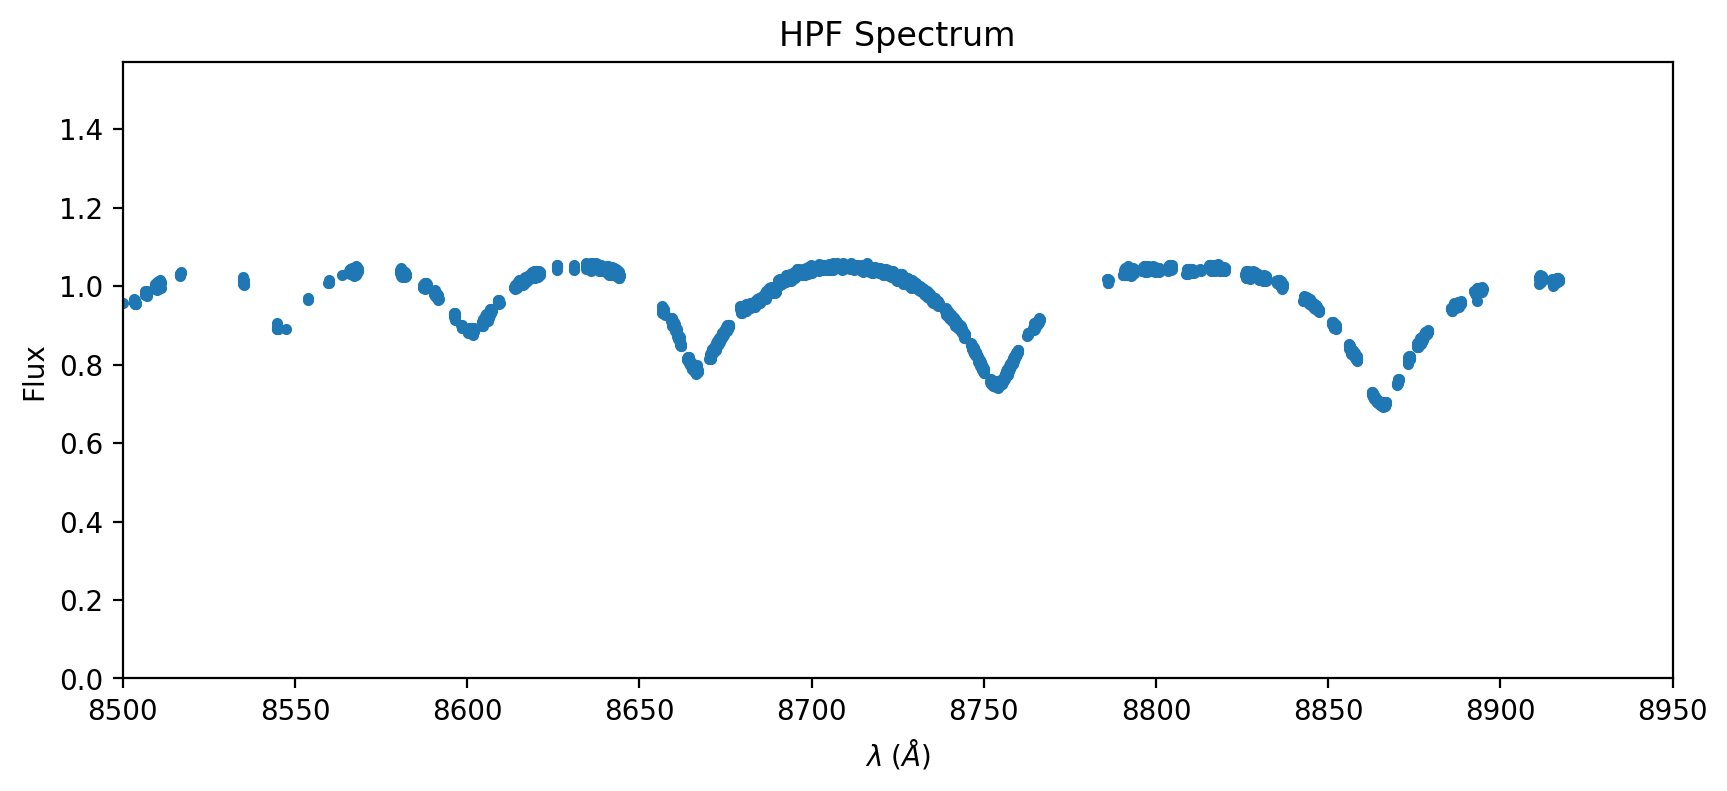

In [6]:
ax = data.plot(marker='.', linestyle='None')
ax.set_xlim(8500, 8950)
plt.show()

OK, that's our data spectrum against which we will compare models.  You can see large voids in the spectrum due to our telluric masking-- that's fine, the data need not be contiguous or evenly sampled to estimate a best fit model.  We will resample the model to the data.

We can choose 3 dimensions in our grid: $T_{\mathrm{eff}}, \log(g), \left[\mathrm{Fe}/\mathrm{H}\right]$

In [7]:
template = PHOENIXSpectrum(teff=9600, logg=4.5, Z=0, download=True)

We then want to rotationally broaden and RV shift the spectrum.  We'll guess the $v\sin(i)$ and $v_r$ values to be 150 km/s and -50 km/s, respectively:

In [8]:
spec = template.rotationally_broaden(150).rv_shift(-50).instrumental_broaden(55000).resample(data).normalize()

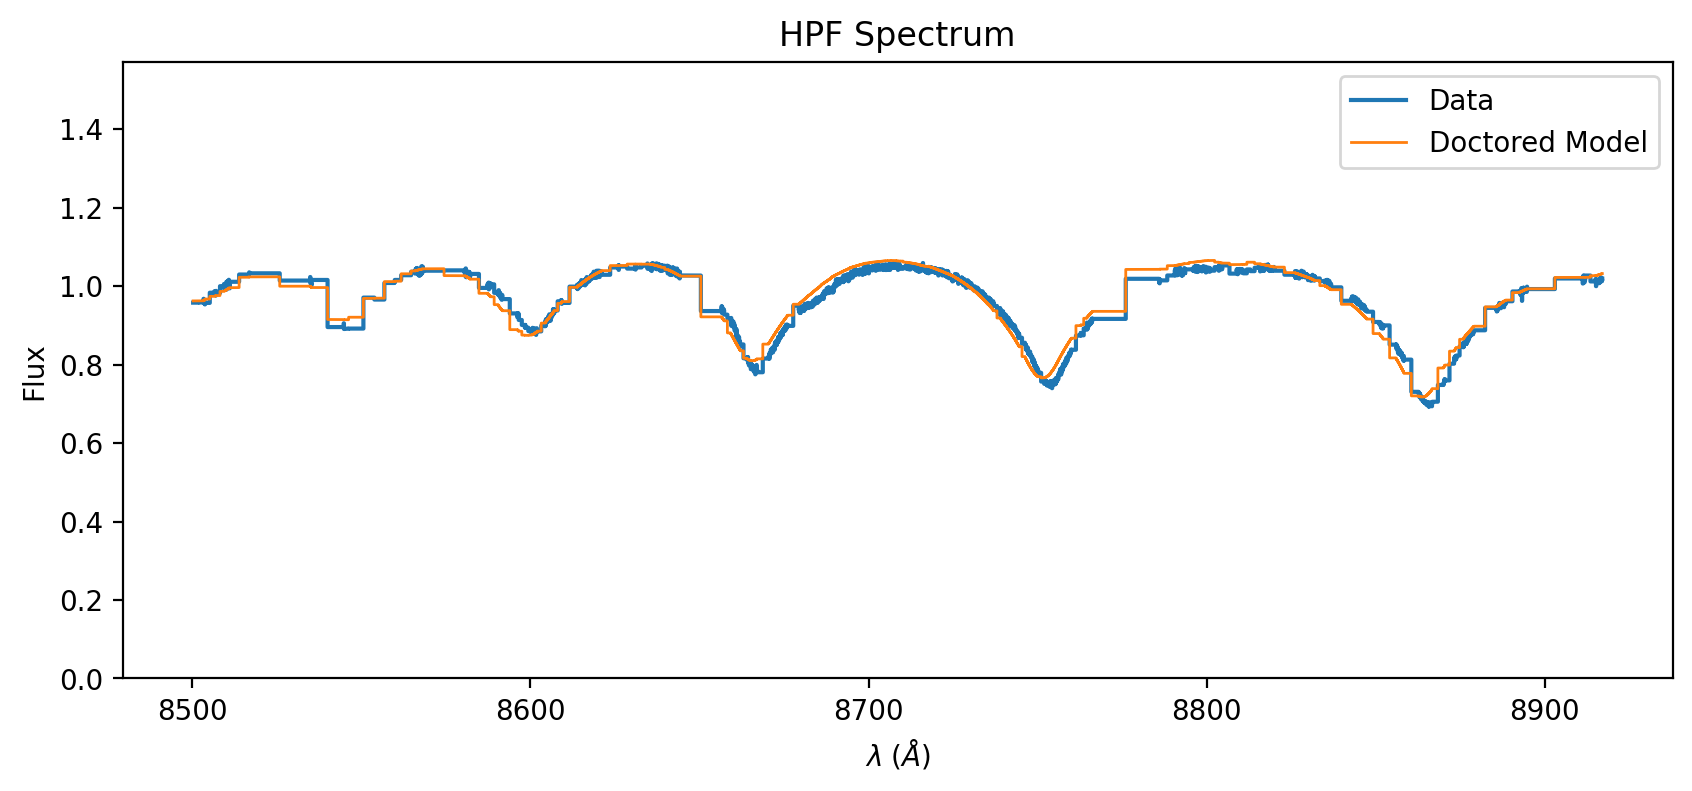

In [9]:
ax = data.plot(label='Data')
spec.plot(ax=ax, label='Doctored Model')
ax.legend()
plt.show()

You can see that our guesses are off.  Let's do a grid search for $v\sin(i)$ and $v_r$.

In [10]:
vsinis = np.linspace(1, 150, 20)
rvs = np.linspace(-100, 100, 20)
search_vsini, search_rv = np.meshgrid(vsinis, rvs, indexing='ij')

We will compute the RSS (Residual Sum-of-Squares) loss for each value of $v\sin(i)$ and $v_r$.

In [11]:
@np.vectorize
def rss(vsini, rv):
    model = template.rotationally_broaden(vsini).rv_shift(rv).instrumental_broaden(55000).resample(data).normalize()
    return np.sum((data.flux - model.flux)**2)

In [12]:
loss = rss(search_vsini, search_rv)

In [13]:
best_i, best_j = np.unravel_index(np.argmin(loss), (20, 20))
best_vsini, best_rv = vsinis[best_i], rvs[best_j]
best_vsini, best_rv

(102.94736842105263, 15.789473684210535)

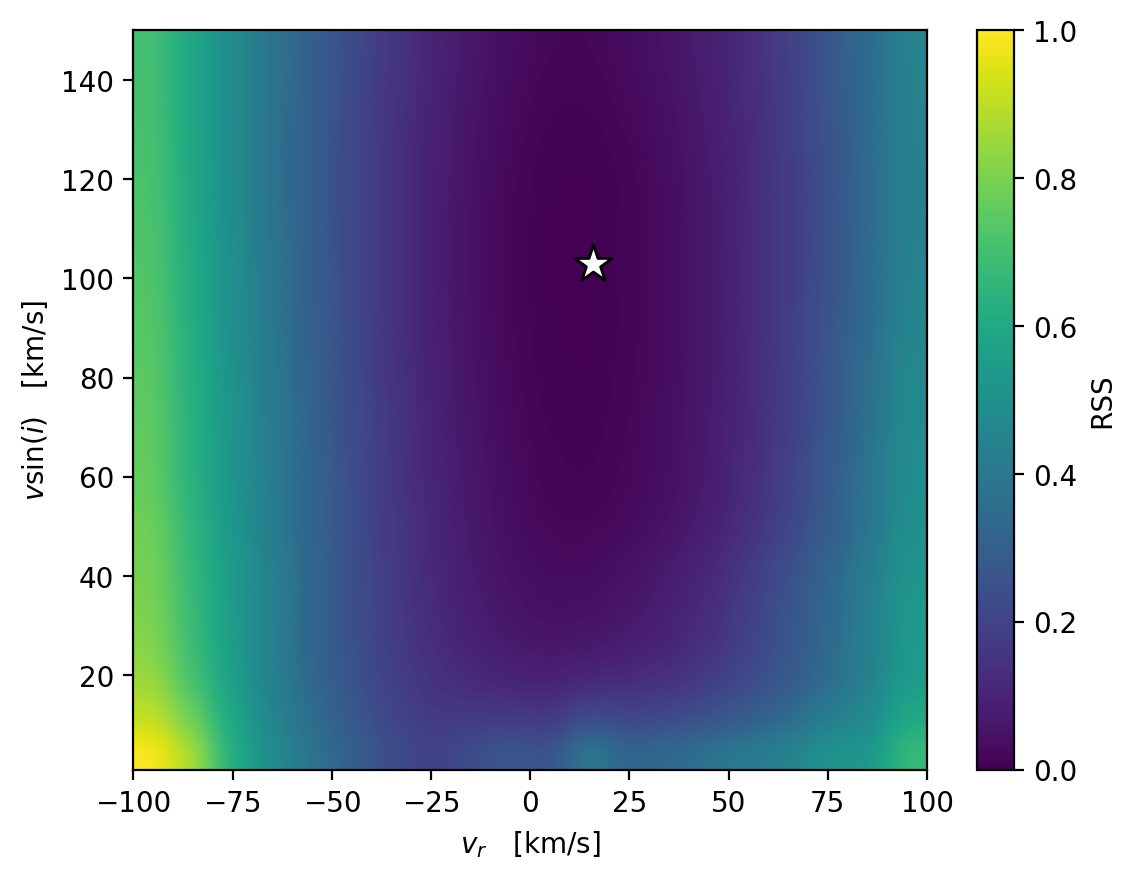

In [14]:
plt.imshow(loss, extent=[rvs.min(), rvs.max(), vsinis.min(), vsinis.max()], aspect='auto', origin='lower', interpolation='gaussian')
plt.scatter(best_rv, best_vsini,  marker='*', c='w', ec='k', s=200)
plt.colorbar(label='RSS')
plt.xlabel(r'$v_r \quad [\mathrm{km}/\mathrm{s}]$')
plt.ylabel(r'$v\sin(i) \quad [\mathrm{km}/\mathrm{s}]$')
plt.show()

Awesome, we have found the $v\sin{i}$ and $v_r$ with the closest match to the data.

In [15]:
best_spec_full = template.rotationally_broaden(best_vsini).rv_shift(best_rv).instrumental_broaden(resolving_power=55000)
best_spec = best_spec_full[data.wavelength.min():data.wavelength.max()].normalize()

How does the best fit look by-eye?

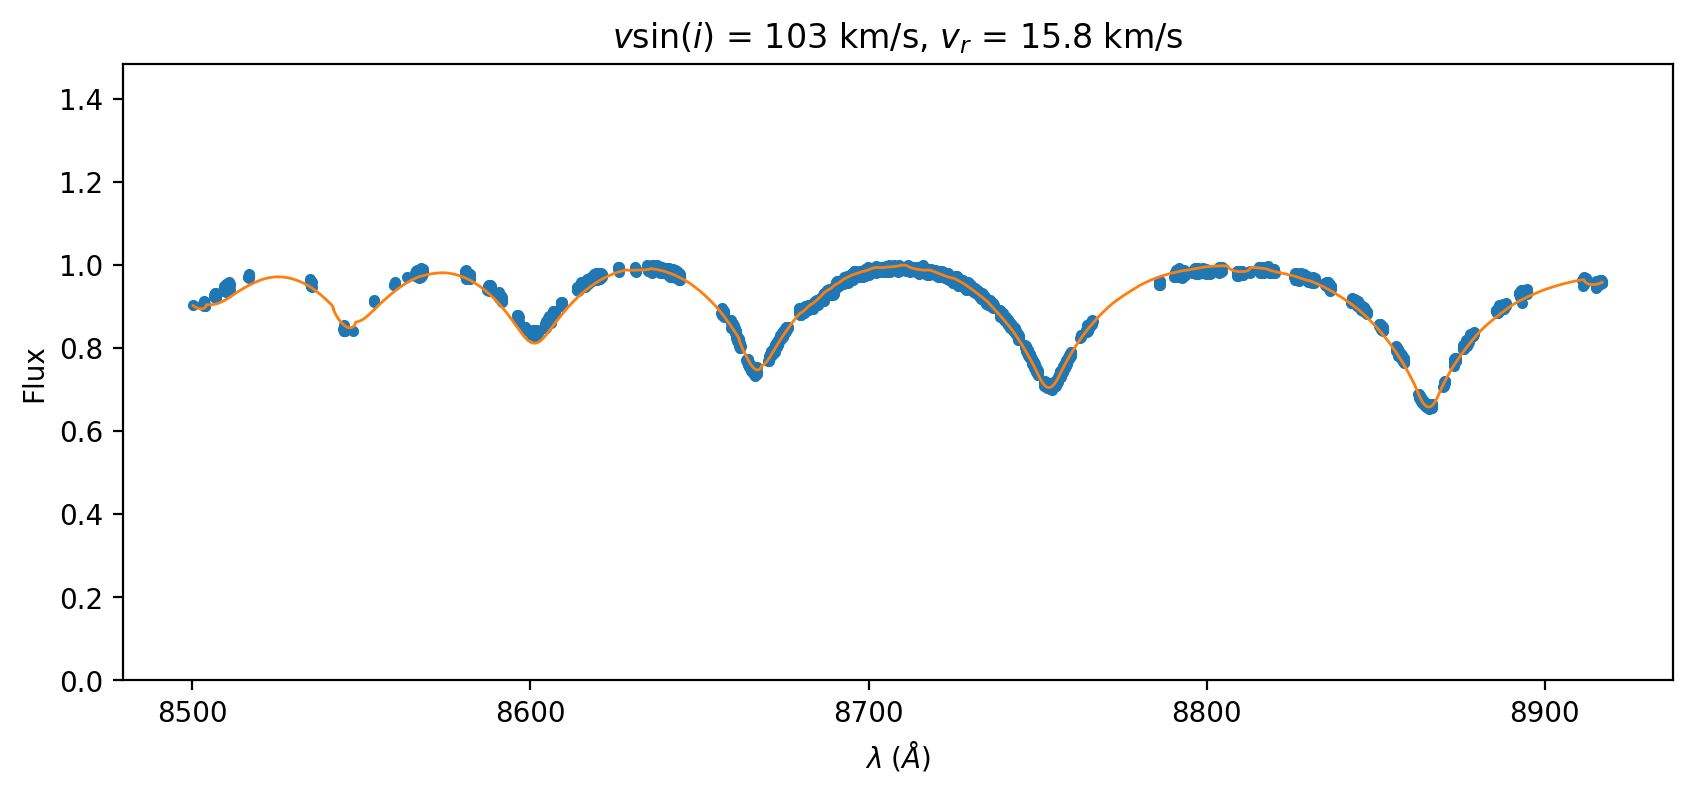

In [16]:
ax = (data/data.flux.max()).plot(marker='.', linestyle='None')
(best_spec/best_spec.flux.max()).plot(ax=ax)
ax.set_title(rf'$v\sin(i)$ = {best_vsini:0.0f} km/s, $v_r$ = {best_rv:0.1f} km/s')
plt.show()

Excellent!  That's much better than our initial guess.